<a href="https://colab.research.google.com/github/sarahaptumich/capstone/blob/shaptonstall/breaker_ranking_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Mount google drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Github/capstone

/content/drive/MyDrive/Github/capstone


In [3]:
%ls

 Capstone.ipynb           pd2       pd.png                               trivium_pca.pkl
 data_exploration.ipynb   pd2.png   __pycache__/                         trivium_scaler.pkl
 glicko2.py               pd3       README.md                            trivium_scorecard.csv
 pd                       pd3.png  'trivium_full_column_names (1).csv'   Webscraping.xlsx


In [4]:
!pip install skelo

In [5]:
import sys
sys.path.append('/content/drive/MyDrive/Github/capstone')

In [6]:
import pandas as pd
import numpy as np
import re
from datetime import datetime, timedelta
from sklearn.decomposition import PCA, KernelPCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import FactorAnalysis
import joblib
from sklearn.preprocessing import LabelEncoder
from skelo.model.elo import EloEstimator

In [7]:
#load models if needed
scaler = joblib.load('trivium_scaler.pkl')
pca= joblib.load('trivium_pca.pkl')

In [8]:
#load files
trivium= pd.read_csv('trivium_scorecard.csv')
webscraping = pd.read_excel('Webscraping.xlsx', sheet_name=None)
webscraping.keys()

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


dict_keys(['Events and8', 'Events', 'Events WDSF', 'Battles Trivium', 'Battles and8 Threefold', 'Battles and8 Single Slider', 'Battles and8 Round by Round', 'Battles and8 Traditional', 'Research Questions', 'Notes', 'Notes Columns'])

In [9]:
#Load battle winners
#threefold
threefold = webscraping['Battles and8 Threefold']
threefold.rename(columns={'Unnamed: 0':'Event', 'Unnamed: 1': 'Category', 'breaker 1': 'breaker 1 (red)', 'breaker 2': 'breaker 2 (blue)'}, inplace=True)
threefold[['Event', 'Category']] = threefold[['Event', 'Category']].fillna(method='ffill')
#Trivium
trivium=webscraping['Battles Trivium']
trivium.rename(columns={'Unnamed: 0':'Event', 'Unnamed: 1': 'Category'}, inplace=True)
trivium[['Event', 'Category']]= trivium[['Event', 'Category']].fillna(method='ffill')
#traditional
traditional = webscraping['Battles and8 Traditional']
traditional.rename(columns={'Unnamed: 0':'Event', 'Unnamed: 1': 'Category'}, inplace=True)
traditional[['Event', 'Category']] = traditional[['Event', 'Category']].fillna(method='ffill')

In [10]:
tr=traditional[['Event', 'Category', 'breaker 1 (red)', 'breaker 2 (blue)', 'winner']].copy()
th=threefold[['Event', 'Category', 'breaker 1 (red)', 'breaker 2 (blue)', 'winner']].copy()
tv=trivium[['Event', 'Category', 'breaker 1 (red)', 'breaker 2 (blue)', 'winner']].copy()

dataframes = [('traditional', tr), ('threefold', th), ('trivium', tv)]

# Create an empty list to store modified dataframes
appended_dfs = []

# Iterate to create a combined dataframe
for name, dframe in dataframes:
    dframe['Original_DF'] = name
    dframe['Battle_ID'] = dframe.index
    appended_dfs.append(dframe)
appendedBattles = pd.concat(appended_dfs, ignore_index=True)


In [11]:
eventsAnd8=webscraping['Events and8'][1:].copy()
new_header= eventsAnd8.iloc[0]
eventsAnd8=eventsAnd8.drop(1)
eventsAnd8.columns = new_header
eventsAnd8.rename(columns={'Name':'Event'}, inplace=True)
eventsAnd8.drop_duplicates(subset=['Event'], inplace=True)

eventsWDSF = webscraping['Events WDSF'][1:].copy()
new_header = eventsWDSF.iloc[0]
eventsWDSF = eventsWDSF.drop(1)
eventsWDSF.columns = new_header
eventsWDSF.rename(columns={'Name': 'Event'}, inplace=True)
eventsWDSF.drop_duplicates(subset=['Event'], inplace=True)

Events = webscraping['Events'][1:].copy()
new_header = Events.iloc[0]
Events = Events.drop(1)
Events.columns = new_header
Events.rename(columns={'Name':'Event'}, inplace=True)
Events.drop_duplicates(subset=['Event'], inplace=True)

combined_events = pd.concat([eventsAnd8, eventsWDSF, Events], ignore_index=True)

In [12]:
#add battle date
appendedBattles=pd.merge(appendedBattles, combined_events[['Date', 'Event']], on='Event', how='left')


In [13]:
appendedBattles['loser'] = np.where(appendedBattles['winner'] == appendedBattles['breaker 1 (red)'], appendedBattles['breaker 2 (blue)'], appendedBattles['breaker 1 (red)'])


In [14]:
appendedBattles['dateKey'] = pd.to_datetime(appendedBattles['Date']).dt.strftime('%Y%m%d').astype(int)
appendedBattles

,Event,Category,breaker 1 (red),breaker 2 (blue),winner,Original_DF,Battle_ID,Date,loser,dateKey
0,Championnat de France 2023,B-Boys +16 Top 16 Round Robin Group D,Kidmario,Noé,Noé,traditional,0,2023-07-05 00:00:00,Kidmario,20230705
1,Championnat de France 2023,B-Boys +16 Top 16 Round Robin Group D,Wilfried,Killian,Killian,traditional,1,2023-07-05 00:00:00,Wilfried,20230705
2,Championnat de France 2023,B-Boys +16 Top 16 Round Robin Group D,Wilfried,Noé,Noé,traditional,2,2023-07-05 00:00:00,Wilfried,20230705
3,Championnat de France 2023,B-Boys +16 Top 16 Round Robin Group D,Kidmario,Killian,Killian,traditional,3,2023-07-05 00:00:00,Kidmario,20230705
4,Championnat de France 2023,B-Boys +16 Top 16 Round Robin Group D,Wilfried,Kidmario,Wilfried,traditional,4,2023-07-05 00:00:00,Kidmario,20230705
...,...,...,...,...,...,...,...,...,...,...
2624,WDSF Pan American Qualifier 2017 - Philadelphia,B-Boys Top 16 Round Robin Group A,Stiv,Rerunn,Rerunn,trivium,1521,2017-06-10 00:00:00,Stiv,20170610
2625,WDSF Pan American Qualifier 2017 - Philadelphia,B-Boys Top 16 Round Robin Group A,Piccolo,Rerunn,Rerunn,trivium,1522,2017-06-10 00:00:00,Piccolo,20170610
2626,WDSF Pan American Qualifier 2017 - Philadelphia,B-Boys Top 16 Round Robin Group A,Piccolo,D-Matt,D-Matt,trivium,1523,2017-06-10 00:00:00,Piccolo,20170610
2627,WDSF Pan American Qualifier 2017 - Philadelphia,B-Boys Top 16 Round Robin Group A,Stiv,D-Matt,D-Matt,trivium,1524,2017-06-10 00:00:00,Stiv,20170610


In [15]:
appendedBattles[['winner', 'loser']]=appendedBattles[['winner', 'loser']].astype(str)


In [16]:
battlesNotide=appendedBattles[appendedBattles['winner']!='Tie'].copy()

In [17]:
battlesNotide.shape, appendedBattles.shape

((2573, 10), (2629, 10))

In [18]:
labels = len(battlesNotide) * [1] # the data are ordered as winner/loser

model = EloEstimator(
  key1_field="winner",
  key2_field="loser",
  timestamp_field="dateKey",
  initial_time=min(appendedBattles['dateKey']),
).fit(battlesNotide, labels)

<Axes: xlabel='valid_from'>

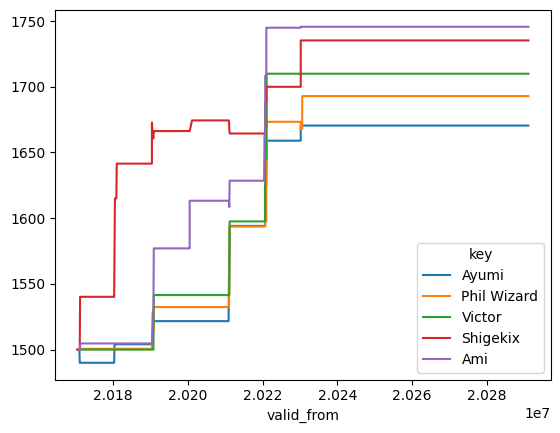

In [19]:
elo_cur_ranking=model.rating_model.to_frame()
ts_est=elo_cur_ranking.pivot_table(index='valid_from', columns='key', values='rating').ffill()
idx = ts_est.iloc[-1].sort_values().index[-5:]
ts_est.loc[:, idx].plot()

In [20]:
elo_cur_ranking=elo_cur_ranking[elo_cur_ranking['valid_to'].isnull()].sort_values(by='rating', ascending=False)

In [21]:
battlesNotide[['elo_winner', 'elo_loser']]=model.transform(battlesNotide, output_type='rating')
battlesNotide

,Event,Category,breaker 1 (red),breaker 2 (blue),winner,Original_DF,Battle_ID,Date,loser,dateKey,elo_winner,elo_loser
0,Championnat de France 2023,B-Boys +16 Top 16 Round Robin Group D,Kidmario,Noé,Noé,traditional,0,2023-07-05 00:00:00,Kidmario,20230705,1489.712256,1500.0
1,Championnat de France 2023,B-Boys +16 Top 16 Round Robin Group D,Wilfried,Killian,Killian,traditional,1,2023-07-05 00:00:00,Wilfried,20230705,1500.000000,1500.0
2,Championnat de France 2023,B-Boys +16 Top 16 Round Robin Group D,Wilfried,Noé,Noé,traditional,2,2023-07-05 00:00:00,Wilfried,20230705,1489.712256,1500.0
3,Championnat de France 2023,B-Boys +16 Top 16 Round Robin Group D,Kidmario,Killian,Killian,traditional,3,2023-07-05 00:00:00,Kidmario,20230705,1500.000000,1500.0
4,Championnat de France 2023,B-Boys +16 Top 16 Round Robin Group D,Wilfried,Kidmario,Wilfried,traditional,4,2023-07-05 00:00:00,Kidmario,20230705,1500.000000,1500.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2624,WDSF Pan American Qualifier 2017 - Philadelphia,B-Boys Top 16 Round Robin Group A,Stiv,Rerunn,Rerunn,trivium,1521,2017-06-10 00:00:00,Stiv,20170610,1500.000000,1500.0
2625,WDSF Pan American Qualifier 2017 - Philadelphia,B-Boys Top 16 Round Robin Group A,Piccolo,Rerunn,Rerunn,trivium,1522,2017-06-10 00:00:00,Piccolo,20170610,1500.000000,1500.0
2626,WDSF Pan American Qualifier 2017 - Philadelphia,B-Boys Top 16 Round Robin Group A,Piccolo,D-Matt,D-Matt,trivium,1523,2017-06-10 00:00:00,Piccolo,20170610,1500.000000,1500.0
2627,WDSF Pan American Qualifier 2017 - Philadelphia,B-Boys Top 16 Round Robin Group A,Stiv,D-Matt,D-Matt,trivium,1524,2017-06-10 00:00:00,Stiv,20170610,1500.000000,1500.0


In [22]:
battlesNotide[['prob_winner', 'prob_loser']]=model.predict_proba(battlesNotide)
battlesNotide['Favorite']= np.where(battlesNotide['prob_winner']> battlesNotide['prob_loser'], battlesNotide['winner'], battlesNotide['loser'])
battlesNotide

,Event,Category,breaker 1 (red),breaker 2 (blue),winner,Original_DF,Battle_ID,Date,loser,dateKey,elo_winner,elo_loser,prob_winner,prob_loser,Favorite
0,Championnat de France 2023,B-Boys +16 Top 16 Round Robin Group D,Kidmario,Noé,Noé,traditional,0,2023-07-05 00:00:00,Kidmario,20230705,1489.712256,1500.0,0.485199,0.514801,Kidmario
1,Championnat de France 2023,B-Boys +16 Top 16 Round Robin Group D,Wilfried,Killian,Killian,traditional,1,2023-07-05 00:00:00,Wilfried,20230705,1500.000000,1500.0,0.500000,0.500000,Wilfried
2,Championnat de France 2023,B-Boys +16 Top 16 Round Robin Group D,Wilfried,Noé,Noé,traditional,2,2023-07-05 00:00:00,Wilfried,20230705,1489.712256,1500.0,0.485199,0.514801,Wilfried
3,Championnat de France 2023,B-Boys +16 Top 16 Round Robin Group D,Kidmario,Killian,Killian,traditional,3,2023-07-05 00:00:00,Kidmario,20230705,1500.000000,1500.0,0.500000,0.500000,Kidmario
4,Championnat de France 2023,B-Boys +16 Top 16 Round Robin Group D,Wilfried,Kidmario,Wilfried,traditional,4,2023-07-05 00:00:00,Kidmario,20230705,1500.000000,1500.0,0.500000,0.500000,Kidmario
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2624,WDSF Pan American Qualifier 2017 - Philadelphia,B-Boys Top 16 Round Robin Group A,Stiv,Rerunn,Rerunn,trivium,1521,2017-06-10 00:00:00,Stiv,20170610,1500.000000,1500.0,0.500000,0.500000,Stiv
2625,WDSF Pan American Qualifier 2017 - Philadelphia,B-Boys Top 16 Round Robin Group A,Piccolo,Rerunn,Rerunn,trivium,1522,2017-06-10 00:00:00,Piccolo,20170610,1500.000000,1500.0,0.500000,0.500000,Piccolo
2626,WDSF Pan American Qualifier 2017 - Philadelphia,B-Boys Top 16 Round Robin Group A,Piccolo,D-Matt,D-Matt,trivium,1523,2017-06-10 00:00:00,Piccolo,20170610,1500.000000,1500.0,0.500000,0.500000,Piccolo
2627,WDSF Pan American Qualifier 2017 - Philadelphia,B-Boys Top 16 Round Robin Group A,Stiv,D-Matt,D-Matt,trivium,1524,2017-06-10 00:00:00,Stiv,20170610,1500.000000,1500.0,0.500000,0.500000,Stiv
